## Imported Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
sns.set()

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/frame

### Raw data

In [2]:
raw_data = pd.read_csv('Human_Resources.csv')
print(raw_data['Age'].describe())
raw_data.head()

count    1470.000000
mean       36.923810
std         9.135373
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: Age, dtype: float64


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### Data Pre-processing

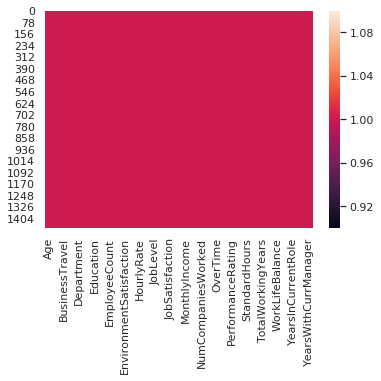

   Attrition Over18  OverTime
0          1      1         1
1          0      1         0
2          1      1         1
3          0      1         1
4          0      1         0


In [3]:
sns.heatmap(raw_data.notnull())
plt.show()
raw_data['Attrition'] = raw_data['Attrition'].replace({'Yes': 1, 'No': 0})
raw_data['OverTime'] = raw_data['OverTime'].replace({'Yes': 1, 'No': 0})
raw_data['Over18'] = raw_data['Over18'].replace({'Y': 1, 'N': 0})


reformed_data = raw_data.copy()
print(reformed_data[['Attrition', 'Over18', 'OverTime']].head())

### Data distribution for each feature

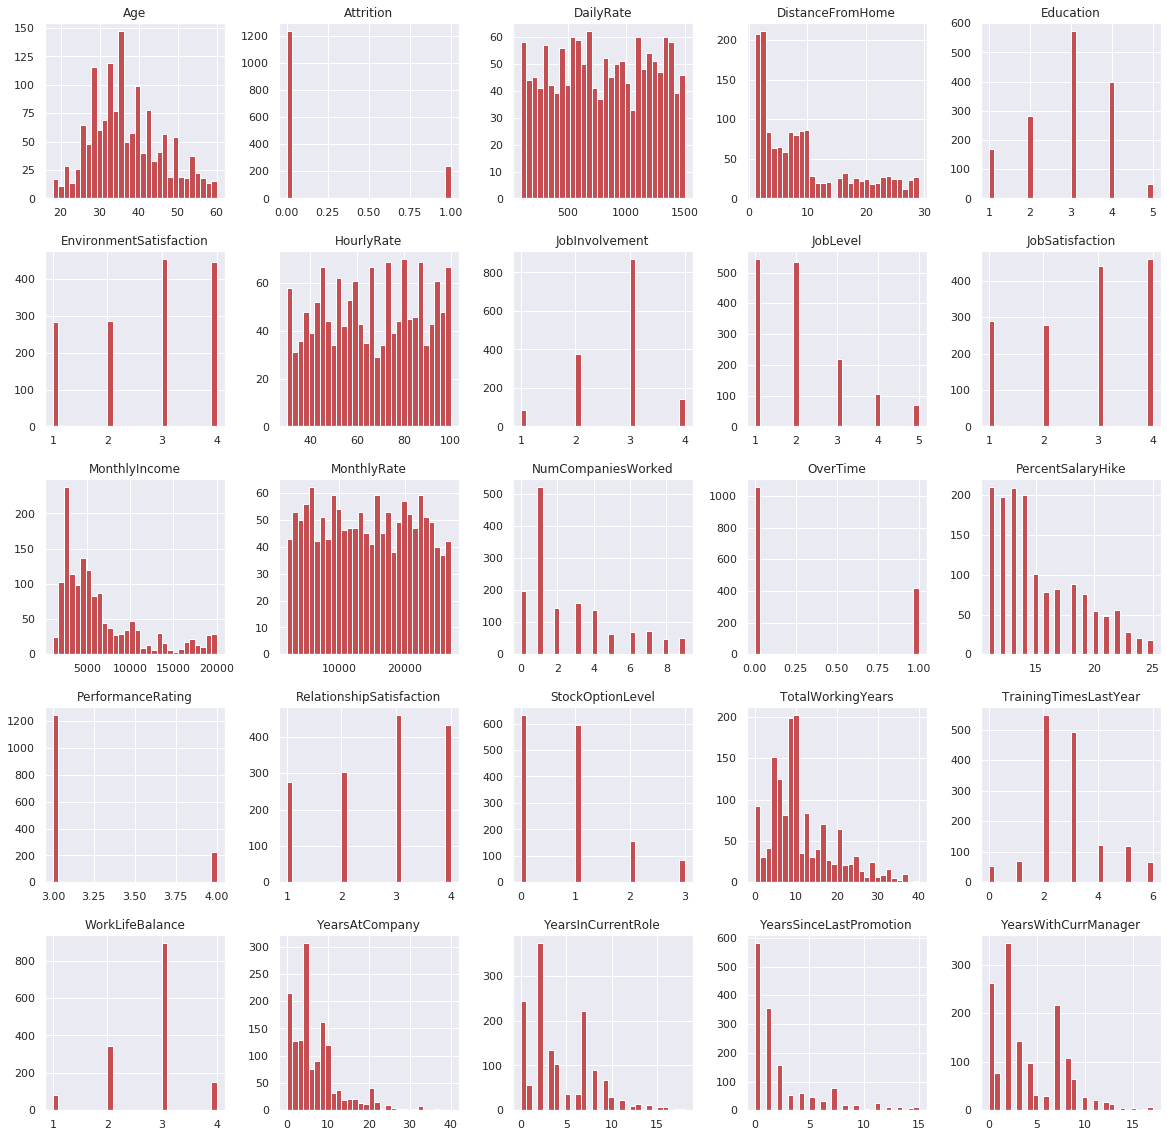

In [4]:
reformed_data.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1, inplace=True)
reformed_data.hist(bins=30, figsize=(20,20), color='r')
plt.show()

### EMPLOYEES ATTRITION

In [5]:
stayed_data = reformed_data[reformed_data['Attrition'] == 0]
left_data = reformed_data[reformed_data['Attrition'] == 1]
print('Employees stayed: {0}\nEmployees left: {1}'.format(len(stayed_data), len(left_data)))

Employees stayed: 1233
Employees left: 237


### Correlation between features

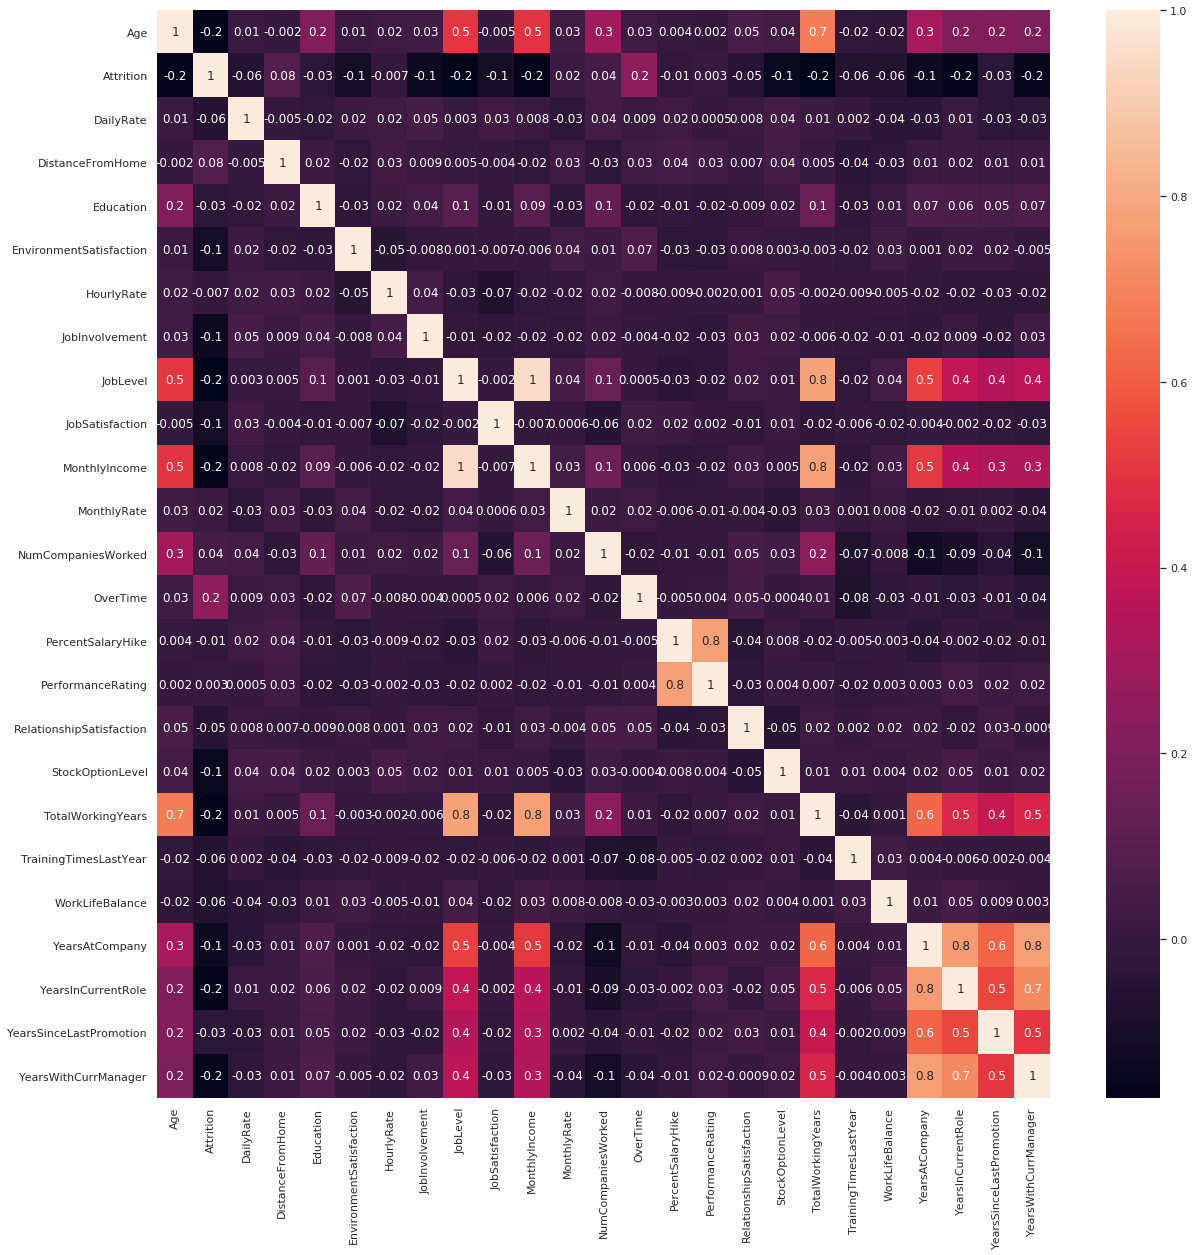

In [6]:
correlations = reformed_data.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlations, annot=True,fmt='.1g')
plt.show()

### Attrition bar graph for each feature

In [7]:
def attrition_bar_graphs(m_var, s_var, data):
    plt.figure(figsize=[25, 12])
    sns.countplot(x=m_var, hue=s_var, data=data)
    plt.show()


In [8]:
attrition_columns =['Age', 'MaritalStatus','JobRole']

Age


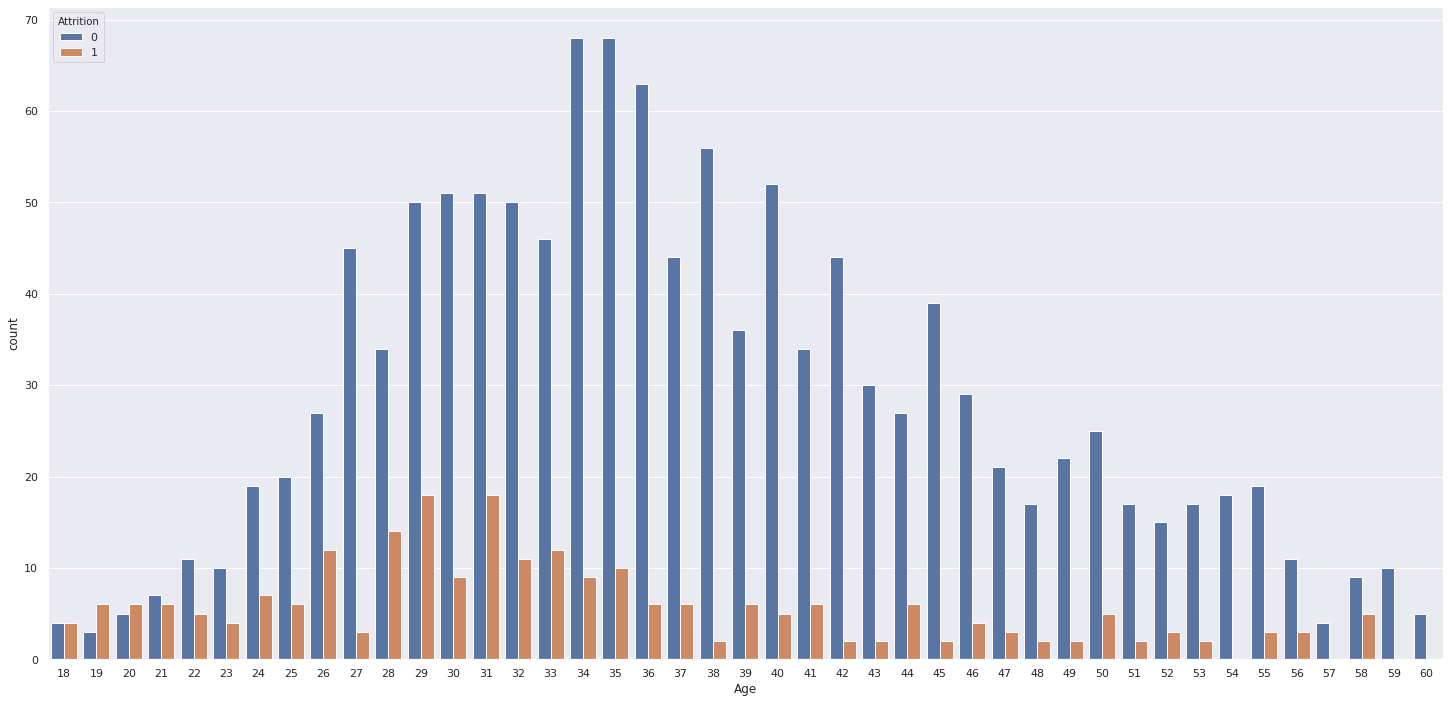

MaritalStatus


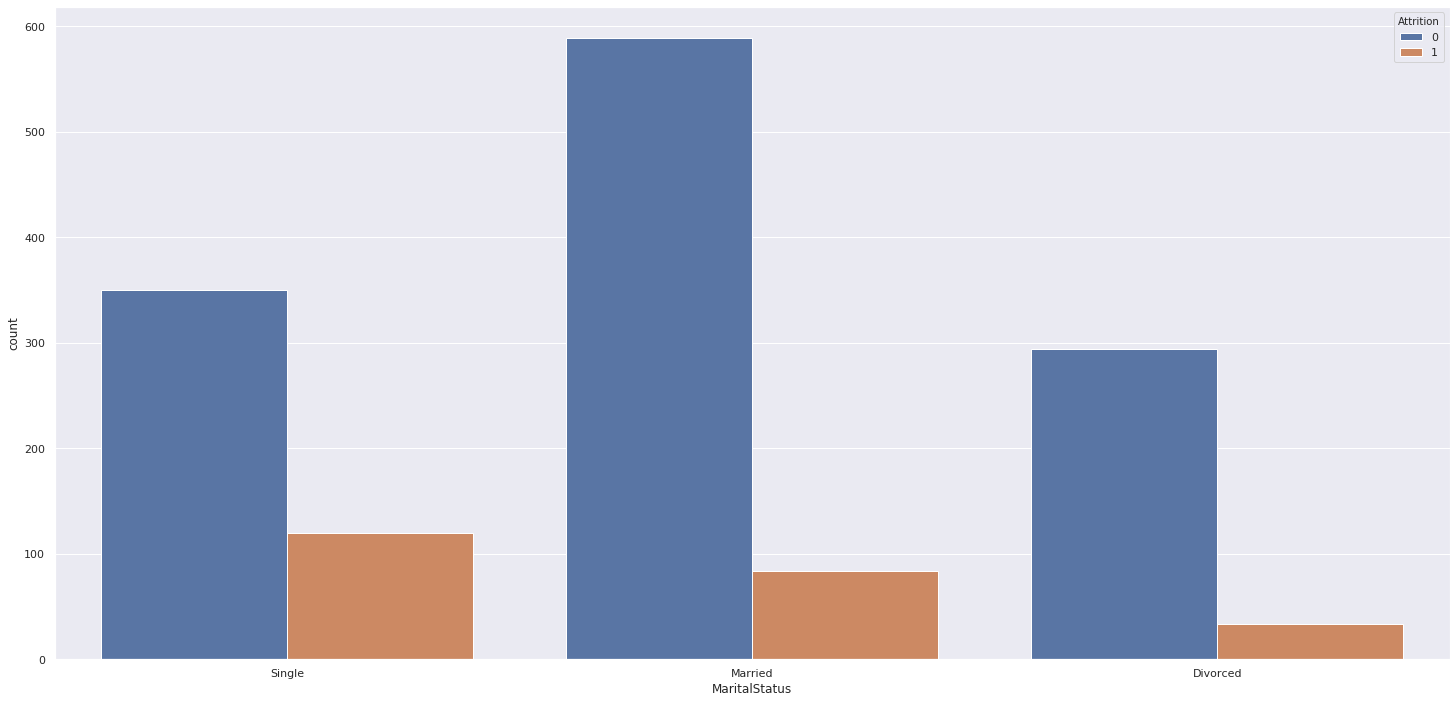

JobRole


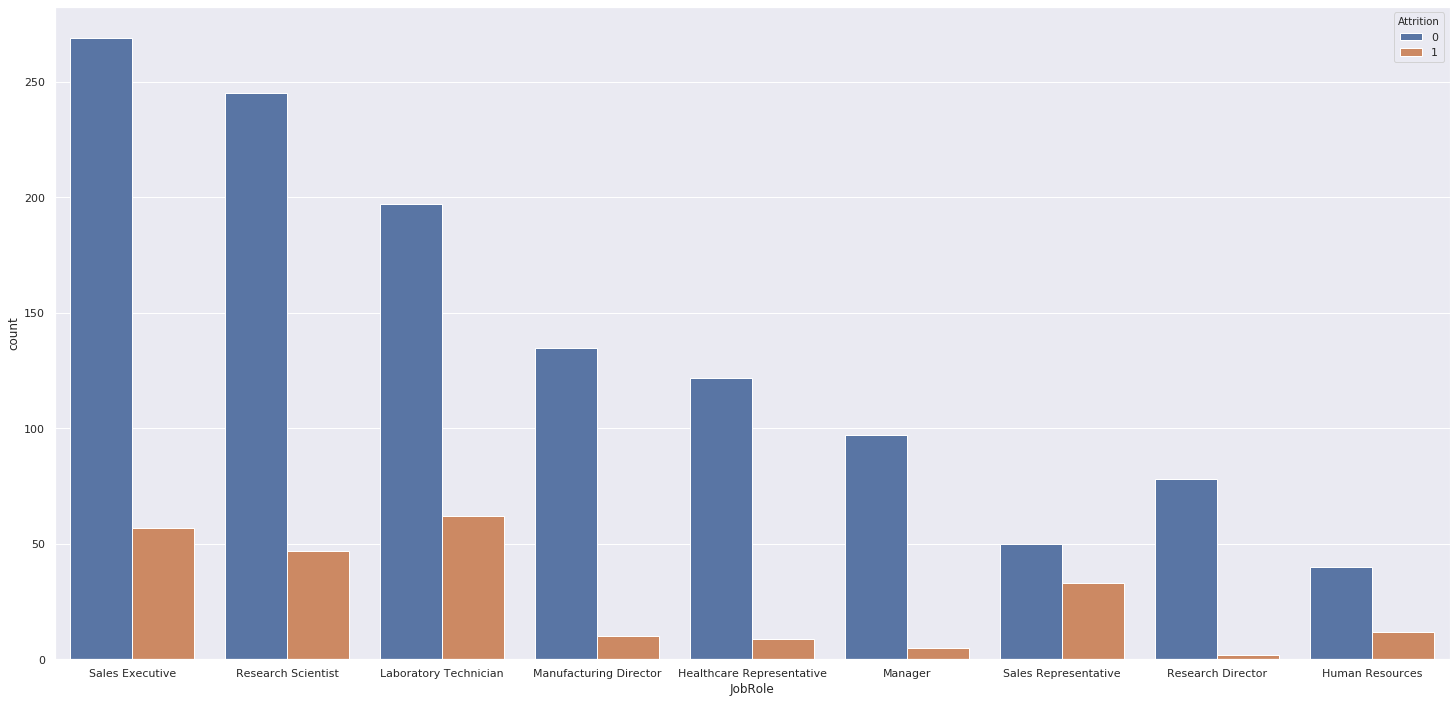

In [9]:
for i in attrition_columns:
    print(i)
    plt.figure(figsize=[25, 12])
    sns.countplot(x=i, hue='Attrition', data=reformed_data)
    plt.show()

In [10]:
def kde_plot_attrition(left_data, stayed_data, i):
    plt.figure(figsize=(12,7))
    sns.kdeplot(left_data['{}'.format(i)], label = 'Employees who left', shade = True, color = 'r')
    sns.kdeplot(stayed_data['{}'.format(i)], label = 'Employees who Stayed', shade = True, color = 'b')
    plt.xlabel('{}'.format(i))

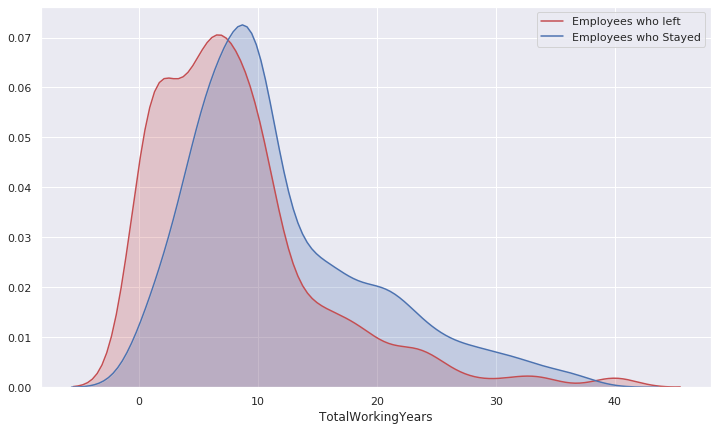

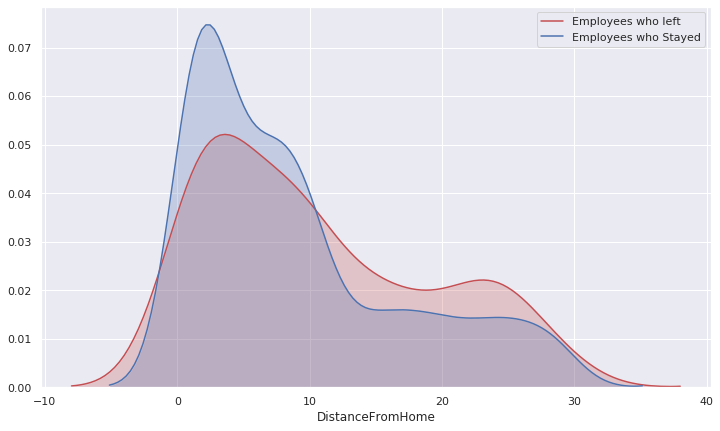

In [11]:
kde_columns = ['TotalWorkingYears','DistanceFromHome']
for i in kde_columns:
    kde_plot_attrition(left_data, stayed_data, i)

## Feature Selcetion

### Categorical

In [12]:
X_categorical = reformed_data[['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']]
X_categorical = pd.DataFrame(OneHotEncoder().fit_transform(X_categorical).toarray())

### Numerical

In [13]:
X_numerical = reformed_data[['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
                             'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
                             'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
                             'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
                             'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
                             'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']]


### Inputs Scaling

In [14]:
Y = reformed_data['Attrition']

In [15]:
X = MinMaxScaler().fit_transform(pd.concat([X_categorical, X_numerical], axis=1))
X.shape

(1470, 50)

### Split data into train and test

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Models

### Model perfomance function

In [17]:
def test_perfomance(name, prediction, test):
    print("{} Model Accuracy: {} %".format(name,round(100*accuracy_score(prediction, test), 4)))
    plt.figure(len(name))
    sns.heatmap(confusion_matrix(prediction, test), annot=True,cmap="Blues")
    print(classification_report(prediction, test))

### LogReg classifier

logistic Regression Model Accuracy: 89.1156 %
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       273
           1       0.36      0.67      0.47        21

    accuracy                           0.89       294
   macro avg       0.67      0.79      0.70       294
weighted avg       0.93      0.89      0.91       294



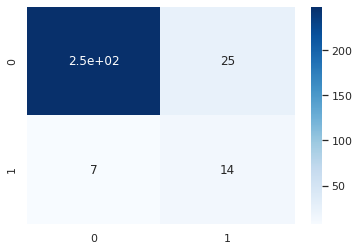

In [18]:
LG_model = (LogisticRegression(solver='lbfgs').fit(X_train, Y_train))
LG_model_pred = LG_model.predict(X_test)
name = 'logistic Regression'
test_perfomance(name, LG_model_pred, Y_test)

### Random Forest classifier

Random Forest Model Accuracy: 87.0748 %
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       289
           1       0.08      0.60      0.14         5

    accuracy                           0.87       294
   macro avg       0.53      0.74      0.53       294
weighted avg       0.98      0.87      0.92       294



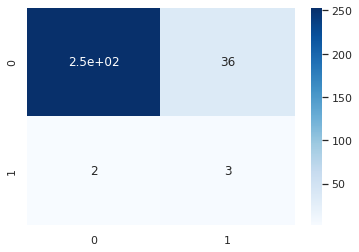

In [19]:
RF_model = (RandomForestClassifier(n_estimators=10).fit(X_train, Y_train))
RF_model_pred = RF_model.predict(X_test)
name = 'Random Forest'
test_perfomance(name, RF_model_pred, Y_test)

### Neural Network model

In [20]:
name='Neural Network'
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=500, activation='relu', input_shape=(50, )))
model.add(tf.keras.layers.Dense(units=500, activation='relu'))
model.add(tf.keras.layers.Dense(units=500, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               25500     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 501       
Total params: 527,001
Trainable params: 527,001
Non-trainable params: 0
_________________________________________________________________


Epoch 1/13
1176/1176 [==============================] - 1s 710us/sample - loss: 2.4062e-04 - acc: 1.0000
Epoch 2/13
1176/1176 [==============================] - 1s 761us/sample - loss: 2.0936e-04 - acc: 1.0000
Epoch 3/13
1176/1176 [==============================] - 1s 765us/sample - loss: 1.8305e-04 - acc: 1.0000
Epoch 4/13
1176/1176 [==============================] - 1s 778us/sample - loss: 1.5980e-04 - acc: 1.0000
Epoch 5/13
1176/1176 [==============================] - 1s 743us/sample - loss: 1.4243e-04 - acc: 1.0000
Epoch 6/13
1176/1176 [==============================] - 1s 768us/sample - loss: 1.2497e-04 - acc: 1.0000
Epoch 7/13
1176/1176 [==============================] - 1s 776us/sample - loss: 1.1207e-04 - acc: 1.0000
Epoch 8/13
1176/1176 [==============================] - 1s 751us/sample - loss: 9.8656e-05 - acc: 1.0000
Epoch 9/13
1176/1176 [==============================] - 1s 775us/sample - loss: 8.7066e-05 - acc: 1.0000
Epoch 10/13
1176/1176 [==============================] 

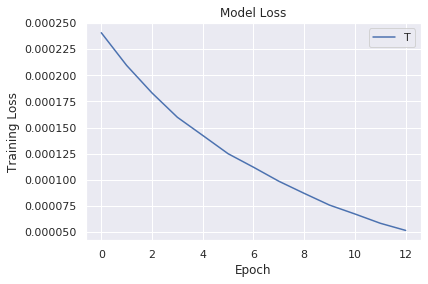

Neural Network Model Accuracy: 87.415 %
              precision    recall  f1-score   support

       False       0.94      0.92      0.93       262
        True       0.44      0.53      0.48        32

    accuracy                           0.87       294
   macro avg       0.69      0.72      0.70       294
weighted avg       0.89      0.87      0.88       294



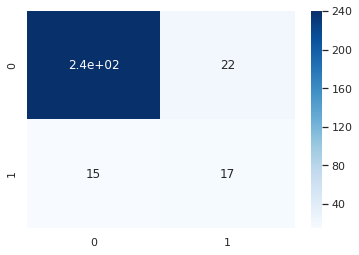

In [25]:
epochs_history = model.fit(X_train, Y_train, epochs = 13, batch_size = 50)
DL_model_pred = model.predict(X_test)
plt.plot(epochs_history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend('Training Loss')
plt.show()
test_perfomance(name, DL_model_pred>0.5, Y_test)

## Save model

In [23]:
with open ('model','wb') as nn_model_file, open('rf_model','wb') as rf_model_file, open('lg_model','wb') as lg_model_file:
    pickle.dump(LG_model,lg_model_file)
    pickle.dump(RF_model,rf_model_file)